Files already downloaded and verified
Image originale depuis CIFAR-10:
 - type: <class 'numpy.ndarray'>
 - shape: (32, 32, 3)
 - dtype: uint8

Après resize (OpenCV):
 - shape: (64, 64, 3)

Après conversion en niveaux de gris (OpenCV):
 - shape: (64, 64)

Tensor PyTorch à partir d'une image OpenCV:
 - shape: torch.Size([3, 64, 64])
 - dtype: torch.float32
 - min, max: 0.003921568859368563 0.9882352948188782
Files already downloaded and verified
Files already downloaded and verified

Taille du dataset:
 - train: 50000
 - test : 10000
Classes CIFAR-10: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Batch d'images récupéré:
 - images.shape: torch.Size([8, 3, 32, 32])
 - labels.shape: torch.Size([8])


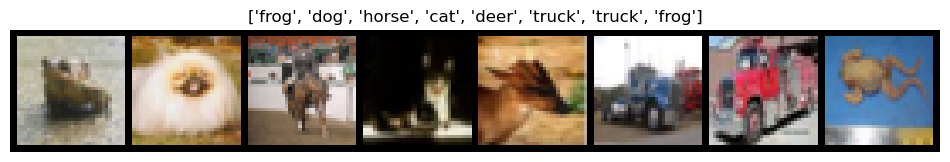


Images envoyées sur: cpu
 - shape: torch.Size([8, 3, 32, 32])
 - device: cpu


In [21]:

import cv2
import torch
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np



# Charger directement une image depuis CIFAR-10 (raw)
train_ds_raw = torchvision.datasets.CIFAR10(root="data", train=True, download=True)
sample_image = train_ds_raw.data[0]  # numpy.ndarray, shape [32,32,3], dtype uint8

print("Image originale depuis CIFAR-10:")
print(" - type:", type(sample_image))
print(" - shape:", sample_image.shape)
print(" - dtype:", sample_image.dtype)


image_bgr = cv2.cvtColor(sample_image, cv2.COLOR_RGB2BGR)


resized = cv2.resize(image_bgr, (64, 64))
print("\nAprès resize (OpenCV):")
print(" - shape:", resized.shape)


gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
print("\nAprès conversion en niveaux de gris (OpenCV):")
print(" - shape:", gray.shape)



tensor = torch.tensor(resized, dtype=torch.float32).permute(2, 0, 1) / 255.0
print("\nTensor PyTorch à partir d'une image OpenCV:")
print(" - shape:", tensor.shape)
print(" - dtype:", tensor.dtype)
print(" - min, max:", tensor.min().item(), tensor.max().item())



transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

train_ds = datasets.CIFAR10(root="data", train=True, transform=transform, download=True)
test_ds  = datasets.CIFAR10(root="data", train=False, transform=transform, download=True)

print("\nTaille du dataset:")
print(" - train:", len(train_ds))
print(" - test :", len(test_ds))
print("Classes CIFAR-10:", train_ds.classes)



train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)

images, labels = next(iter(train_loader))
print("\nBatch d'images récupéré:")
print(" - images.shape:", images.shape)
print(" - labels.shape:", labels.shape)



grid = torchvision.utils.make_grid(images, nrow=8)
npgrid = grid.permute(1, 2, 0).numpy()

plt.figure(figsize=(12, 3))
plt.imshow(npgrid)
plt.axis("off")
plt.title([train_ds.classes[i] for i in labels])
plt.show()



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
images_gpu = images.to(device)
print("\nImages envoyées sur:", device)
print(" - shape:", images_gpu.shape)
print(" - device:", images_gpu.device)


In [23]:
train_loader

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(16*16*16, 10)  # dépend des tailles finales

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # [B,16,16,16]
        x = x.view(x.size(0), -1)  # flatten
        x = self.fc(x)
        return x

model = SimpleCNN()
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(1):  # une seule époque pour test
    for images, labels in train_loader:
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1} - Loss: {loss.item():.4f}")
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy sur test: {100 * correct / total:.2f}%")
